# Prepare Method

In [333]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import random

In [334]:
np.random.seed(8)

In [335]:
def blood_type_to_ohe(data):
  data = pd.get_dummies(data, columns=['blood_type'])
  return data

In [336]:
def extract_features_from_symptoms(data):
  for idx in range(len(data['symptoms'])):
   if isinstance(data['symptoms'].iloc[idx], str):
     data['symptoms'].iloc[idx] = data['symptoms'].iloc[idx].split(';')

  to_concat = data['symptoms'].str.join('|').str.get_dummies()
  data = pd.concat([data, to_concat], axis=1)
  del data['symptoms']
  return data

In [337]:
def sex_to_ohe(data):
  return pd.get_dummies(data, columns=['sex'])

In [338]:
def craft_employed_feature(data):
  employed = [None]*(len(data['job']))

  for idx in range(len(data['job'])):
    if pd.isna(data['job'].iloc[idx]):
      employed[idx] = 0 
    else:
      employed[idx] = 1
  data['employed'] = employed
  del data['job']

  return data


In [339]:
def craft_x_y_coordinates_features(data):
  xs = []
  ys = []

  for idx in range(len(data['current_location'])):
    if isinstance(data['current_location'].iloc[idx], str):
      coordinates = data['current_location'].iloc[idx].split(',')
      xs.append(float(coordinates[0][2:-1])) 
      ys.append(float(coordinates[1][2:-2]))
    else:
      xs.append(float('NaN')) 
      ys.append(float('NaN'))
      
  del data['current_location']
  data['current_location_x_coordinate'] = xs
  data['current_location_y_coordinate'] = ys

  return data


In [340]:
def craft_state_feature(data):
  states = []
  for idx in range(len(data['address'])):
    if isinstance(data['address'].iloc[idx], str):
      add = data['address'].iloc[idx].split(',')
      state = add[-1].split(' ')[1]
    else:
      state = float('NaN')
    states.append(state)

  data['state'] = states
  del data['address']

  return data

In [341]:
def craft_days_since_pcr_feature(data):
  all_dates = []
  pcr_dates = copy.deepcopy(data['pcr_date'])

  for idx in range(len(data['pcr_date'])):
    if isinstance(data['pcr_date'].iloc[idx], str):
      data['pcr_date'].iloc[idx] = data['pcr_date'].iloc[idx][0:4:] + data['pcr_date'].iloc[idx][5::]
      data['pcr_date'].iloc[idx] = data['pcr_date'].iloc[idx][0:6:] + data['pcr_date'].iloc[idx][7::]
      data['pcr_date'].iloc[idx] = float(data['pcr_date'].iloc[idx])
      all_dates.append(data['pcr_date'].iloc[idx])

      
  last_date = max(all_dates)
  last_date_list = [last_date//10000, (last_date%10000)//100, last_date%100]
  last_date_in_days = last_date_list[0]*365 + last_date_list[1]*30 + last_date_list[2]

  for idx in range(0,len(pcr_dates)):
    if isinstance(pcr_dates.iloc[idx], str):
      date = pcr_dates.iloc[idx].split('-')
      for i in range(len(date)):
        date[i] = float(date[i])
      pcr_dates.iloc[idx] = date

  for i in range(len(pcr_dates)):
    if isinstance(pcr_dates.iloc[i], list):
      pcr_dates.iloc[i] = pcr_dates.iloc[i][0]*365 + pcr_dates.iloc[i][1]*30 + pcr_dates.iloc[i][2]
      pcr_dates.iloc[i] = last_date_in_days - pcr_dates.iloc[i]

  data['days_since_pcr'] = pcr_dates
  del data['pcr_date']

  return data

In [342]:
def clean_outliers_IQR(data):
  features_to_clean = ['current_location_x_coordinate','current_location_y_coordinate', 'days_since_pcr' , 'num_of_siblings', 'household_income',
                     'conversations_per_day', 'happiness_score', 'sport_activity', 'age',
                     'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']
  
  for feature in features_to_clean:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    mean = data[feature].mean()
    for idx in range(len(data[feature])):
      if (data[feature].iloc[idx] < (Q1 - 1.5 * IQR)) or (data[feature].iloc[idx] > (Q3 + 1.5 * IQR)):
        data[feature].iloc[idx] = mean
        if feature == 'age':
          data[feature].iloc[idx] = Q3 + 1.5*IQR
  return data

In [343]:
  def calculate_weight_IQR_limits_by_age(train, age):
    weights=[]
    for idx in range(len(train['age'])):
      if not(math.isnan(train['age'].iloc[idx])) and not(math.isnan(train['weight'].iloc[idx])):
        if train['age'].iloc[idx]<50:
          diff = 0
        else:
          diff = 11
        if abs((train['age'].iloc[idx]) - age) <= diff :
            weights.append(train['weight'].iloc[idx])
    if weights == []:
      general_mean = train['weight'].mean()
      return general_mean, general_mean, general_mean
    weights_df = pd.DataFrame(weights)
    Q1 = weights_df[0].quantile(0.25)
    Q3 = weights_df[0].quantile(0.75)
    Q2 = weights_df[0].quantile(0.5)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR, Q2


In [344]:
def clean_weight_outliers_by_age(train, test):
  array_of_low_limit_high_limit_Q2_from_age_1_to_60 = []
  for i in range(0,61):
    array_of_low_limit_high_limit_Q2_from_age_1_to_60.append([0.0,0.0,0.0])
  for age in range(0,61):
    array_of_low_limit_high_limit_Q2_from_age_1_to_60[age] = calculate_weight_IQR_limits_by_age(train, age)
  mean_general = train['weight'].mean()
  upper_general_limit =  train['weight'].quantile(0.75) + 1.5*(train['weight'].quantile(0.75)-train['weight'].quantile(0.25))
  for idx in range(len(train['patient_id'])):
    if not math.isnan(train['weight'].iloc[idx]):
      if not(math.isnan(train['age'].iloc[idx])): #if age exist
        if  60 < train['age'].iloc[idx]:
          train['weight'].iloc[idx] = mean_general
        low_limit, high_limit, Q2 = array_of_low_limit_high_limit_Q2_from_age_1_to_60[int(train['age'].iloc[idx])]
        if  high_limit < train['weight'].iloc[idx]:
          train['weight'].iloc[idx] = Q2
      else:
        if upper_general_limit<train['weight'].iloc[idx]:
          train['weight'].iloc[idx] = mean_general
  for idx in range(len(test['patient_id'])):
    if not math.isnan(test['weight'].iloc[idx]):
      if not(math.isnan(test['age'].iloc[idx])): #if age exist
        if  60 < test['age'].iloc[idx]:
          test['weight'].iloc[idx] = mean_general
        low_limit, high_limit, Q2 = array_of_low_limit_high_limit_Q2_from_age_1_to_60[int(test['age'].iloc[idx])]
        if  high_limit < test['weight'].iloc[idx]:
          test['weight'].iloc[idx] = Q2
      else:
        if upper_general_limit<test['weight'].iloc[idx]:
          test['weight'].iloc[idx] = mean_general
  
  return test, train

In [345]:
def calculate_sugar_levels_IQR_limits_by_weight(train, weight):
  sugar_levels_list=[]
  for idx in range(len(train['sugar_levels'])):
    if not(math.isnan(train['sugar_levels'].iloc[idx])) and not(math.isnan(train['weight'].iloc[idx])):
      if train['weight'].iloc[idx] <= 100 and 5 <= train['weight'].iloc[idx]:
        diff = 5
      else:
        diff = 20
      if abs((train['weight'].iloc[idx]) - weight) <= diff :
        sugar_levels_list.append(train['sugar_levels'].iloc[idx])
  if sugar_levels_list == []:
    general_mean = train['sugar_levels'].mean()
    return general_mean, general_mean, general_mean
  sugar_levels_df = pd.DataFrame(sugar_levels_list)
  Q1 = sugar_levels_df[0].quantile(0.25)
  Q3 = sugar_levels_df[0].quantile(0.75)
  Q2 = sugar_levels_df[0].quantile(0.5)
  IQR = Q3 - Q1
  return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR, Q2

In [346]:
def clean_sugar_levels_outliers_by_weight(train, test):
  array_of_low_limit_high_limit_Q2_from_weight_1_to_140 = []
  for i in range(1,142):
    array_of_low_limit_high_limit_Q2_from_weight_1_to_140.append([0.0,0.0,0.0])
  for weight in range(1,141):
    array_of_low_limit_high_limit_Q2_from_weight_1_to_140[weight] = calculate_sugar_levels_IQR_limits_by_weight(train, weight)
  mean_general = train['sugar_levels'].mean()
  upper_general_limit =  train['sugar_levels'].quantile(0.75) + 1.5*(train['sugar_levels'].quantile(0.75)-train['sugar_levels'].quantile(0.25))
  for idx in range(len(train['patient_id'])):
    if not math.isnan(train['sugar_levels'].iloc[idx]):
      if not(math.isnan(train['weight'].iloc[idx])): #if weight exist
        if 140 < train['weight'].iloc[idx]:
          train['sugar_levels'].iloc[idx] = mean_general
        low_limit, high_limit, Q2 = array_of_low_limit_high_limit_Q2_from_weight_1_to_140[int(train['weight'].iloc[idx])]
        if  high_limit < train['sugar_levels'].iloc[idx]:
          train['sugar_levels'].iloc[idx] = Q2
      else:
        if upper_general_limit<train['sugar_levels'].iloc[idx]:
          train['sugar_levels'].iloc[idx] = mean_general

  for idx in range(len(test['patient_id'])):
    if not math.isnan(test['sugar_levels'].iloc[idx]):
      if not(math.isnan(test['weight'].iloc[idx])): #if weight exist
        if 140 < test['weight'].iloc[idx]:
          test['sugar_levels'].iloc[idx] = mean_general
        low_limit, high_limit, Q2 = array_of_low_limit_high_limit_Q2_from_weight_1_to_140[int(test['weight'].iloc[idx])]
        if  high_limit < test['sugar_levels'].iloc[idx]:
          test['sugar_levels'].iloc[idx] = Q2
      else:
        if upper_general_limit<test['sugar_levels'].iloc[idx]:
          test['sugar_levels'].iloc[idx] = mean_general
  
  return test, train


In [347]:
def clean_outliers_from_pcr_tests(data):
  PCR_TESTS = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']

  for pcr_test in PCR_TESTS:
    for patient in range(len(data[pcr_test])):
      if data['days_since_pcr'].iloc[patient] >= 389 and data['days_since_pcr'].iloc[patient] <= 407:
        data[pcr_test].iloc[patient] = float('NaN')
  return data

In [348]:
def fill_missing_blood_types(data):
  features_to_impute = ['blood_type_A+', 'blood_type_A-', 'blood_type_B+', 'blood_type_B-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_O+', 'blood_type_O-']
  for idx in range(len(data['patient_id'])):
    isempty = 1
    for feature in features_to_impute:
      isempty = isempty and (data[feature].iloc[idx] == 0)
    if isempty:
      data[random.choice(features_to_impute)].iloc[idx] = 1
     
  return data

In [349]:
def fill_missing_data_with_mean(train, test):
  features_to_impute = ['current_location_x_coordinate','current_location_y_coordinate', 'days_since_pcr' , 'num_of_siblings', 'household_income',
                        'conversations_per_day', 'happiness_score', 'sport_activity',
                        'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']
  for feature in features_to_impute:
      mean = train[feature].mean()
      for idx in range(len(train[feature])):
        if math.isnan(train[feature].iloc[idx]):
          train[feature].iloc[idx] = mean
      for idx in range(len(test[feature])):
        if math.isnan(test[feature].iloc[idx]):
          test[feature].iloc[idx] = mean
  return test, train


In [350]:
def calculate_average_weight_by_sex_and_age(sex, age, train):
  sum_of_weights = 0
  num_of_weights = 0
  for idx in range(len(train[sex])):
    if not (math.isnan(train[sex].iloc[idx])) and not(math.isnan(train['age'].iloc[idx])) and not(math.isnan(train['weight'].iloc[idx])):
      if train[sex].iloc[idx] == 1 and abs((train['age'].iloc[idx]) - age) <= 2 :
            sum_of_weights+=train['weight'].iloc[idx]
            num_of_weights+=1
  if num_of_weights != 0:
    return sum_of_weights/num_of_weights
  return 0

In [351]:
def choose_M_or_F_by_weight_and_age(weight, age, train):
  female_average_in_this_age = calculate_average_weight_by_sex_and_age('sex_F', age, train)
  male_average_in_this_age = calculate_average_weight_by_sex_and_age('sex_M', age, train)
  diff_from_female = abs(female_average_in_this_age - weight)
  diff_from_male = abs(male_average_in_this_age - weight)
  if diff_from_female < diff_from_male:
    return 'sex_F'
  else:
    return 'sex_M'

In [352]:
def get_55_percents_female():
  return np.random.choice(['sex_F', 'sex_M'], p=[0.55, 0.45])


In [353]:
def fill_missing_sex_by_weight(train, test):
  for idx in range(len(train['patient_id'])):
    if train['sex_F'].iloc[idx] == 0 and train['sex_M'].iloc[idx] == 0:
      if not(math.isnan(train['age'].iloc[idx])) and not(math.isnan(train['weight'].iloc[idx])):
        M_or_F = choose_M_or_F_by_weight_and_age(train['weight'].iloc[idx], train['age'].iloc[idx], train)
        train[M_or_F].iloc[idx] = 1
      else:
        train[get_55_percents_female()].iloc[idx] = 1

  for idx in range(len(test['patient_id'])):
    if test['sex_F'].iloc[idx] == 0 and test['sex_M'].iloc[idx] == 0:
      if not(math.isnan(test['age'].iloc[idx])) and not(math.isnan(test['weight'].iloc[idx])):
        M_or_F = choose_M_or_F_by_weight_and_age(test['weight'].iloc[idx], test['age'].iloc[idx], train)
        test[M_or_F].iloc[idx] = 1
      else:
        test[get_55_percents_female()].iloc[idx] = 1
        
  return test, train

In [354]:
def fill_missing_weight_by_age(train, test):
  for idx in range(len(train['patient_id'])):
    if math.isnan(train['weight'].iloc[idx]):
      sex = 'sex_F'
      if train['sex_M'].iloc[idx] == 1:
        sex = 'sex_M'
      if  not(math.isnan(train['age'].iloc[idx])):
        train['weight'].iloc[idx] = calculate_average_weight_by_sex_and_age(sex, train['age'].iloc[idx], train)
      else:
        train['weight'].iloc[idx] = train['weight'].mean()

  for idx in range(len(test['patient_id'])):
    if math.isnan(test['weight'].iloc[idx]):
      sex = 'sex_F'
      if test['sex_M'].iloc[idx] == 1:
        sex = 'sex_M'
      if not(math.isnan(test['age'].iloc[idx])):
        test['weight'].iloc[idx] = calculate_average_weight_by_sex_and_age(sex, test['age'].iloc[idx], train)
      else:
        test['weight'].iloc[idx] = train['weight'].mean()

  return test, train    

In [355]:
def fill_missing_sugar_levels_by_weight(train, test):
  for idx in range(len(train['patient_id'])):
    if math.isnan(train['sugar_levels'].iloc[idx]):
      x,y,Q2 = calculate_sugar_levels_IQR_limits_by_weight(train, train['weight'].iloc[idx])
      train['sugar_levels'].iloc[idx] = Q2
  
  for idx in range(len(test['patient_id'])):
    if math.isnan(test['sugar_levels'].iloc[idx]):
      x,y,Q2 = calculate_sugar_levels_IQR_limits_by_weight(train, test['weight'].iloc[idx])
      test['sugar_levels'].iloc[idx] = Q2

  return test, train


In [356]:
def calculate_average_age_by_weight(train, weight):
  list_of_ages = []
  for idx in range(len(train['patient_id'])):
    if  not(math.isnan(train['age'].iloc[idx])) and not(math.isnan(train['weight'].iloc[idx])):
      if abs((train['weight'].iloc[idx]) - weight) <= 5 :
            list_of_ages.append(train['age'].iloc[idx])
  if list_of_ages == []:
    return train['age'].mean()
  return sum(list_of_ages) / len(list_of_ages)


In [357]:
def fill_missing_age_by_weight(train, test):
  for idx in range(len(train['patient_id'])):
    if math.isnan(train['age'].iloc[idx]):
      train['age'].iloc[idx] = calculate_average_age_by_weight(train, train['weight'].iloc[idx])
  
  for idx in range(len(test['patient_id'])):
    if math.isnan(test['age'].iloc[idx]):
      test['age'].iloc[idx] = calculate_average_age_by_weight(train, test['weight'].iloc[idx])

  return test, train
    

In [358]:
def change_data_to_binary(data):
  covid_b = [None]*len(data['patient_id'])
  for idx in range(len(data['covid'])):
    if data['covid'].iloc[idx]:
      covid_b[idx] = float(1)
    else:
      covid_b[idx] = float(-1)
  data['covid'] = covid_b

  risk_b = [None]*len(data['patient_id'])
  for idx in range(len(data['risk'])):
    if data['risk'].iloc[idx] == 'High':
      risk_b[idx] = float(1)
    if data['risk'].iloc[idx] == 'Low':
      risk_b[idx] = float(-1)
  data['risk'] = risk_b

  spread_b = [None]*len(data['patient_id'])
  for idx in range(len(data['spread'])):
    if data['spread'].iloc[idx] == 'High':
      spread_b[idx] = float(1)
    if data['spread'].iloc[idx] == 'Low':
      spread_b[idx] = float(-1)
  data['spread'] = spread_b

  return data


In [359]:
def normalize_data(data):
  
  feature_and_scaler = { 'age': MinMaxScaler(), 'num_of_siblings': MinMaxScaler(), 
                       'household_income': MinMaxScaler(), 'conversations_per_day': StandardScaler(), 
                       'sugar_levels': StandardScaler(), 'PCR_01': StandardScaler(), 'PCR_02': StandardScaler(), 
                       'PCR_03': StandardScaler(), 'PCR_04': StandardScaler(), 'PCR_05': StandardScaler(), 
                       'PCR_07': StandardScaler(), 'PCR_08': StandardScaler(), 'PCR_10': StandardScaler(), 
                      #  'blood_type_A+': MinMaxScaler(), 'blood_type_A-': MinMaxScaler(), 'blood_type_AB+': MinMaxScaler(), 
                      #  'blood_type_AB-': MinMaxScaler(), 'blood_type_B+': MinMaxScaler(), 'blood_type_B-': MinMaxScaler(), 
                      #  'blood_type_O+': MinMaxScaler(), 'blood_type_O-': MinMaxScaler(), 
                       'cough': MinMaxScaler(), 
                       'fever': MinMaxScaler(), 'headache': MinMaxScaler(), 'low_appetite': MinMaxScaler(), 
                       'shortness_of_breath': MinMaxScaler(), 'sex_F': MinMaxScaler(), 'current_location_x_coordinate': MinMaxScaler(), 
                       'current_location_y_coordinate': MinMaxScaler(), 'days_since_pcr': StandardScaler() }

  for feature in feature_and_scaler:
    (feature_and_scaler[feature]).fit(data[[feature]])
    data[feature] = (feature_and_scaler[feature]).transform(data[[feature]])
  
  return data

In [360]:
def prepare_data(data, training_data):
  np.random.seed(8)

  train_copy = copy.deepcopy(training_data)
  data_copy = copy.deepcopy(data)
  
  # transform blood type to ohe
  data_copy = blood_type_to_ohe(data_copy)
  train_copy = blood_type_to_ohe(train_copy)

  # extracting features from symptoms
  data_copy = extract_features_from_symptoms(data_copy)
  train_copy = extract_features_from_symptoms(train_copy)


  # convert sex feature to ohe
  data_copy = sex_to_ohe(data_copy)
  train_copy = sex_to_ohe(train_copy)
  

  # craft new feature 'employed' from job feature
  data_copy = craft_employed_feature(data_copy)
  train_copy = craft_employed_feature(train_copy)


  # craft new features 'x_coordinates' and 'y_coordinates' from 'current_location' feature
  train_copy = craft_x_y_coordinates_features(train_copy)
  data_copy = craft_x_y_coordinates_features(data_copy)


  # craft new feature 'state' from 'address' feature
  data_copy = craft_state_feature(data_copy)
  train_copy = craft_state_feature(train_copy)


  # craft new feature 'days_since_pcr' from 'pcr_date' feature
  data_copy = craft_days_since_pcr_feature(data_copy)
  train_copy = craft_days_since_pcr_feature(train_copy)
    
  # cleaning outliers from pcr tests
  data_copy = clean_outliers_from_pcr_tests(data_copy)
  train_copy = clean_outliers_from_pcr_tests(train_copy)


  # cleaning outliers by IQR based technique
  data_copy = clean_outliers_IQR(data_copy)
  train_copy = clean_outliers_IQR(train_copy)


  # clean weight feature by age feature (of the training data!)
  data_copy, train_copy = clean_weight_outliers_by_age(train_copy, data_copy)


  # clean sugar_levels feature by weight feature (of the training data!)
  data_copy, train_copy = clean_sugar_levels_outliers_by_weight(train_copy, data_copy)


##################
  # fill missing blood types
  data_copy = fill_missing_blood_types(data_copy)
  train_copy = fill_missing_blood_types(train_copy)


  # fill missing num_of_siblings in test according to train median
  median = train_copy.num_of_siblings.median()
  data_copy['num_of_siblings'] = data_copy.num_of_siblings.fillna(data_copy.num_of_siblings.median())
  train_copy['num_of_siblings'] = train_copy.num_of_siblings.fillna(train_copy.num_of_siblings.median())


  # fill missing data of some features in test with means of same features in train
  data_copy, train_copy = fill_missing_data_with_mean(train_copy, data_copy)


  # fill missing sex with weight
  data_copy, train_copy = fill_missing_sex_by_weight(train_copy, data_copy)


  # fill missing weight by age and sex
  data_copy, train_copy = fill_missing_weight_by_age(train_copy, data_copy)


  # fill missing sugar_levels by weight
  data_copy, train_copy = fill_missing_sugar_levels_by_weight(train_copy, data_copy)


  # fill missing age by weight
  data_copy, train_copy = fill_missing_age_by_weight(train_copy, data_copy)


  # change data to -1,1
  # data_copy = change_data_to_binary(data_copy)

  del data_copy['weight']
  del data_copy['sex_M']
  del data_copy['PCR_06']
  del data_copy['PCR_09']
  del data_copy['happiness_score']
  del data_copy['sport_activity']
  del data_copy['employed']
  del data_copy['state']

  del train_copy['weight']
  del train_copy['sex_M']
  del train_copy['PCR_06']
  del train_copy['PCR_09']
  del train_copy['happiness_score']
  del train_copy['sport_activity']
  del train_copy['employed']
  del train_copy['state']
  # normalize data
  data_copy = normalize_data(data_copy)
  train_copy = normalize_data(train_copy)

  return train_copy, data_copy 
  

# Load Data

In [361]:
data = pd.read_csv('virus_labeled.csv')                                                                  
train, test = train_test_split(data, test_size=0.2, random_state=8)


train, test = prepare_data(test, train)
# #train = prepare_data(train, train)


# train_clean = train.copy()
# test_clean = test.copy()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Section 1

## Q1

In [362]:
train.head()

,patient_id,age,num_of_siblings,household_income,conversations_per_day,sugar_levels,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_07,PCR_08,PCR_10,VirusScore,blood_type_A+,blood_type_A-,blood_type_AB+,blood_type_AB-,blood_type_B+,blood_type_B-,blood_type_O+,blood_type_O-,cough,fever,headache,low_appetite,shortness_of_breath,sex_F,current_location_x_coordinate,current_location_y_coordinate,days_since_pcr
2758,4126,0.030769,0.666667,0.319165,-9.597661e-01,-0.680412,2.198456e-17,-1.851233,0.690545,0.205996,0.074363,-0.153725,0.663354,0.053964,0.33,0,0,1,0,0,0,0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.814160,0.525443,0.000000
2388,6904,0.830769,0.500000,0.822177,-5.463079e-01,0.762415,1.847002e-01,1.775460,-1.273599,1.060212,0.074363,0.303455,0.716775,1.815227,0.15,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.678369,0.480022,0.059484
137,14355,0.153846,0.166667,0.003742,-1.836123e-16,0.540442,-2.545320e-01,-1.817479,-1.103918,1.473467,-1.197466,-0.076736,0.000000,-0.826667,0.35,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.817720,0.481864,0.973931
506,11696,0.707692,0.500000,0.126375,-5.463079e-01,0.706922,4.594262e-01,1.418768,1.451712,-1.401316,-1.197466,0.127806,0.455092,1.815227,0.22,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.718208,0.247308,0.353642
2712,5167,0.400000,0.666667,0.350878,6.940667e-01,-0.846892,2.194438e+00,-1.007298,0.924292,0.714133,2.618022,-0.065685,-0.737842,-0.826667,0.35,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.828391,0.465575,0.097852


In [363]:
blood_type = [None]*(len(train['patient_id']))
blood_types = ['blood_type_A+', 'blood_type_A-', 'blood_type_B+', 'blood_type_B-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_O+', 'blood_type_O-']
for person in range(len(train['patient_id'])):
  for idx in range(len(blood_types)):
    if train[blood_types[idx]].iloc[person] == 1:
      blood_type[person] = blood_types[idx][11:]
      


In [364]:
train['blood_type'] = blood_type

In [365]:
train['blood_type'].isnull().sum()

0

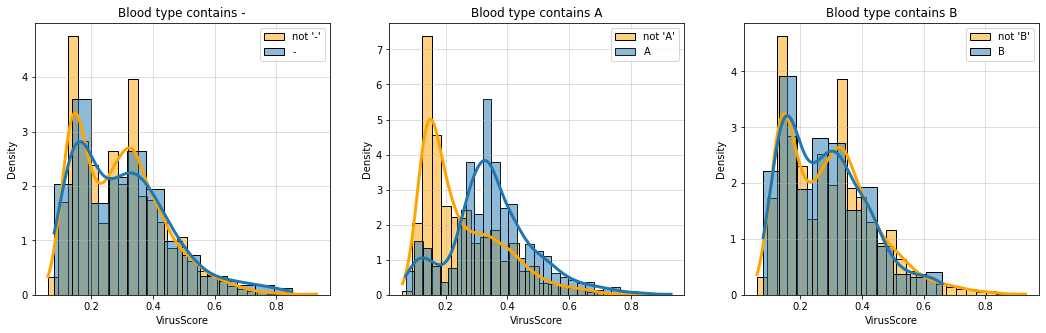

In [366]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, cur_type in enumerate(['-', 'A', 'B']):
 filter_mask = train['blood_type'].str.contains(cur_type)
 sns.histplot(data=train['VirusScore'][~filter_mask], ax=ax[i], stat="density", kde=True,
 line_kws={"linewidth": 3}, color="orange", label="not '{}'".format(cur_type))
 sns.histplot(data=train['VirusScore'][filter_mask], ax=ax[i], stat="density", kde=True,
 line_kws={"linewidth": 3}, label=cur_type)
 ax[i].set_title("Blood type contains " + cur_type)
 ax[i].legend(), ax[i].grid(alpha=0.5)

##Q2

In [367]:
blood_types_with_A = train['blood_type'].str.contains('A')
blood_types_with_A = blood_types_with_A.astype(int)
train['blood_type_contains_A'] = blood_types_with_A


In [368]:
train = train.drop(columns=['blood_type', 'blood_type_A+', 'blood_type_A-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_B+',
                            'blood_type_B-', 'blood_type_O+', 'blood_type_O-'])

In [369]:
train.head()

,patient_id,age,num_of_siblings,household_income,conversations_per_day,sugar_levels,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_07,PCR_08,PCR_10,VirusScore,cough,fever,headache,low_appetite,shortness_of_breath,sex_F,current_location_x_coordinate,current_location_y_coordinate,days_since_pcr,blood_type_contains_A
2758,4126,0.030769,0.666667,0.319165,-9.597661e-01,-0.680412,2.198456e-17,-1.851233,0.690545,0.205996,0.074363,-0.153725,0.663354,0.053964,0.33,0.0,0.0,1.0,1.0,0.0,1.0,0.814160,0.525443,0.000000,1
2388,6904,0.830769,0.500000,0.822177,-5.463079e-01,0.762415,1.847002e-01,1.775460,-1.273599,1.060212,0.074363,0.303455,0.716775,1.815227,0.15,0.0,0.0,0.0,0.0,0.0,1.0,0.678369,0.480022,0.059484,0
137,14355,0.153846,0.166667,0.003742,-1.836123e-16,0.540442,-2.545320e-01,-1.817479,-1.103918,1.473467,-1.197466,-0.076736,0.000000,-0.826667,0.35,0.0,0.0,0.0,0.0,0.0,0.0,0.817720,0.481864,0.973931,0
506,11696,0.707692,0.500000,0.126375,-5.463079e-01,0.706922,4.594262e-01,1.418768,1.451712,-1.401316,-1.197466,0.127806,0.455092,1.815227,0.22,0.0,0.0,0.0,0.0,0.0,1.0,0.718208,0.247308,0.353642,0
2712,5167,0.400000,0.666667,0.350878,6.940667e-01,-0.846892,2.194438e+00,-1.007298,0.924292,0.714133,2.618022,-0.065685,-0.737842,-0.826667,0.35,0.0,0.0,0.0,0.0,0.0,0.0,0.828391,0.465575,0.097852,0


# Section 2

In [370]:
train2, validation = train_test_split(train, test_size = 0.2, random_state = 8)

### Linear Regressor Module

In [371]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
  """
  Custom linear regression model
  """
  def __init__(self, lr: float = 1e-5):
      """
      Initialize an instance of this class.
      ** Do not edit this method **

      :param lr: the SGD learning rate (step size)
      """
      self.lr = lr
      self.batch_size = 32
      self.w = None
      self.b = 0.0

  # Initialize a random weight vector
  def init_solution(self, n_features: int):
      """
      Randomize an initial solution (weight vector)
      ** Do not edit this method **

      :param n_features:
      """
      self.w = np.zeros(n_features)
      self.b = 0.0

  @staticmethod
  def loss(w, b: float, X, y):
      """
      Compute the MSE objective loss.

      :param w: weight vector for linear regression; array of shape (n_features,)
      :param b: bias scalar for linear regression
      :param X: samples for loss computation; array of shape (n_samples, n_features)
      :param y: targets for loss computation; array of shape (n_samples,)
      :return: the linear regression objective loss (float scalar)
      """

      # TODO: complete the loss calculation
      loss = None

      m = X.shape[0]
      b_vector = np.ones(m)*b
      loss = (1/m)*((np.linalg.norm(X.dot(w) + b_vector - y))**2)

      return loss

  @staticmethod
  def gradient(w, b: float, X, y):
      """
      Compute the (analytical) linear regression objective gradient.

      :param w: weight vector for linear regression; array of shape (n_features,)
      :param b: bias scalar for linear regression
      :param X: samples for loss computation; array of shape (n_samples, n_features)
      :param y: targets for loss computation; array of shape (n_samples,)
      :return: a tuple with (the gradient of the weights, the gradient of the bias)
      """
      # TODO: calculate the analytical gradient w.r.t w and b
      g_w = None
      g_b = 0.0

      m = X.shape[0]
      g_w = ((2/m)*(np.transpose(X))).dot(X.dot(w) + np.ones(m)*b - y)

      g_b = ((2/m)*(np.transpose(np.ones(m)))).dot(X.dot(w) + np.ones(m)*b - y)

      return g_w, g_b

  def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                    X_val  =None, y_val = None):
      """
      Fit the model according to the given training data.

      :param X: training samples; array of shape (n_samples, n_features)
      :param y: training targets; array of shape (n_samples,)
      :param max_iter: number of SGD iterations
      :param keep_losses: should compute the train & val losses during training?
      :param X_val: validation samples to compute the loss for (for logs only)
      :param y_val: validation labels to compute the loss for (for logs only)
      :return: training and validation losses during training
      """
      # Initialize learned parameters
      self.init_solution(X.shape[1])

      train_losses = []
      val_losses = []

      if keep_losses:
          train_losses.append(self.loss(self.w, self.b, X, y))
          val_losses.append(self.loss(self.w, self.b, X_val, y_val))

      # Iterate over batches (SGD)
      for itr in range(0, max_iter):
          start_idx = (itr * self.batch_size) % X.shape[0]
          end_idx = min(X.shape[0], start_idx + self.batch_size)
          batch_X = X[start_idx: end_idx]
          batch_y = y[start_idx: end_idx]

          # TODO: Compute the gradient for the current *batch*
          g_w, g_b = self.gradient(self.w, self.b, X, y)

          # Perform a gradient step
          # TODO: update the learned parameters correctly
          self.w = self.w - self.lr * g_w
          self.b = self.b - self.lr * g_b

          if keep_losses:
              train_losses.append(self.loss(self.w, self.b,  X, y))
              val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

      return train_losses, val_losses

  def fit(self, X, y, max_iter: int = 1000):
      """
      Fit the model according to the given training data.
      ** Do not edit this method **

      :param X: training samples; array of shape (n_samples, n_features)
      :param y: training targets; array of shape (n_samples,)
      :param max_iter: number of SGD iterations
      """
      self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

      return self

  def predict(self, X):
      """
      Regress labels on samples in X.

      :param X: samples for prediction; array of shape (n_samples, n_features)
      :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
      """

      # TODO: Compute
      y_pred = None

      m = X.shape[0]
      y_pred = X.dot(self.w) + np.ones(m) * self.b

      return y_pred

### Verify Gradients

In [372]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


##Q4

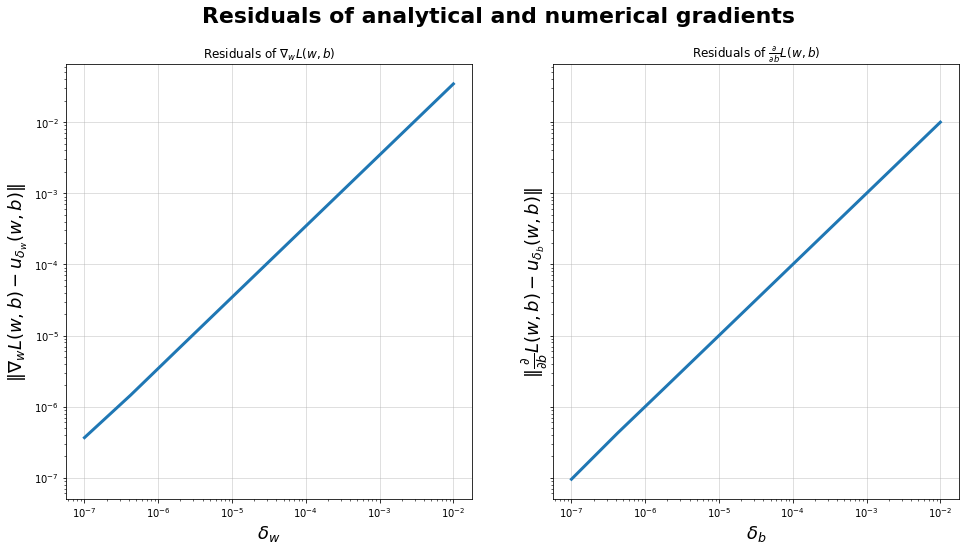

In [373]:
X_train = train2.drop(columns=['VirusScore', 'patient_id'])
y_train = train2['VirusScore']
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

## test LR

In [374]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')


##Q5

lr size = 1e-09, Best train loss = 0.10683741370305165, Best validation loss = 0.10263674271014808
lr size = 1e-08, Best train loss = 0.10682491925798165, Best validation loss = 0.10262430308177521
lr size = 1e-07, Best train loss = 0.10670007152553977, Best validation loss = 0.10250000379614908
lr size = 1e-06, Best train loss = 0.10546121547742945, Best validation loss = 0.10126665996949719
lr size = 1e-05, Best train loss = 0.09398616561478006, Best validation loss = 0.08984928531913461
lr size = 0.0001, Best train loss = 0.03647935320485327, Best validation loss = 0.03302036686495151
lr size = 0.001, Best train loss = 0.013129191887154478, Best validation loss = 0.01192510364662308
lr size = 0.01, Best train loss = 0.008173729746633402, Best validation loss = 0.008491787051292195
lr size = 0.1, Best train loss = 0.008004924193487398, Best validation loss = 0.00844857806558308


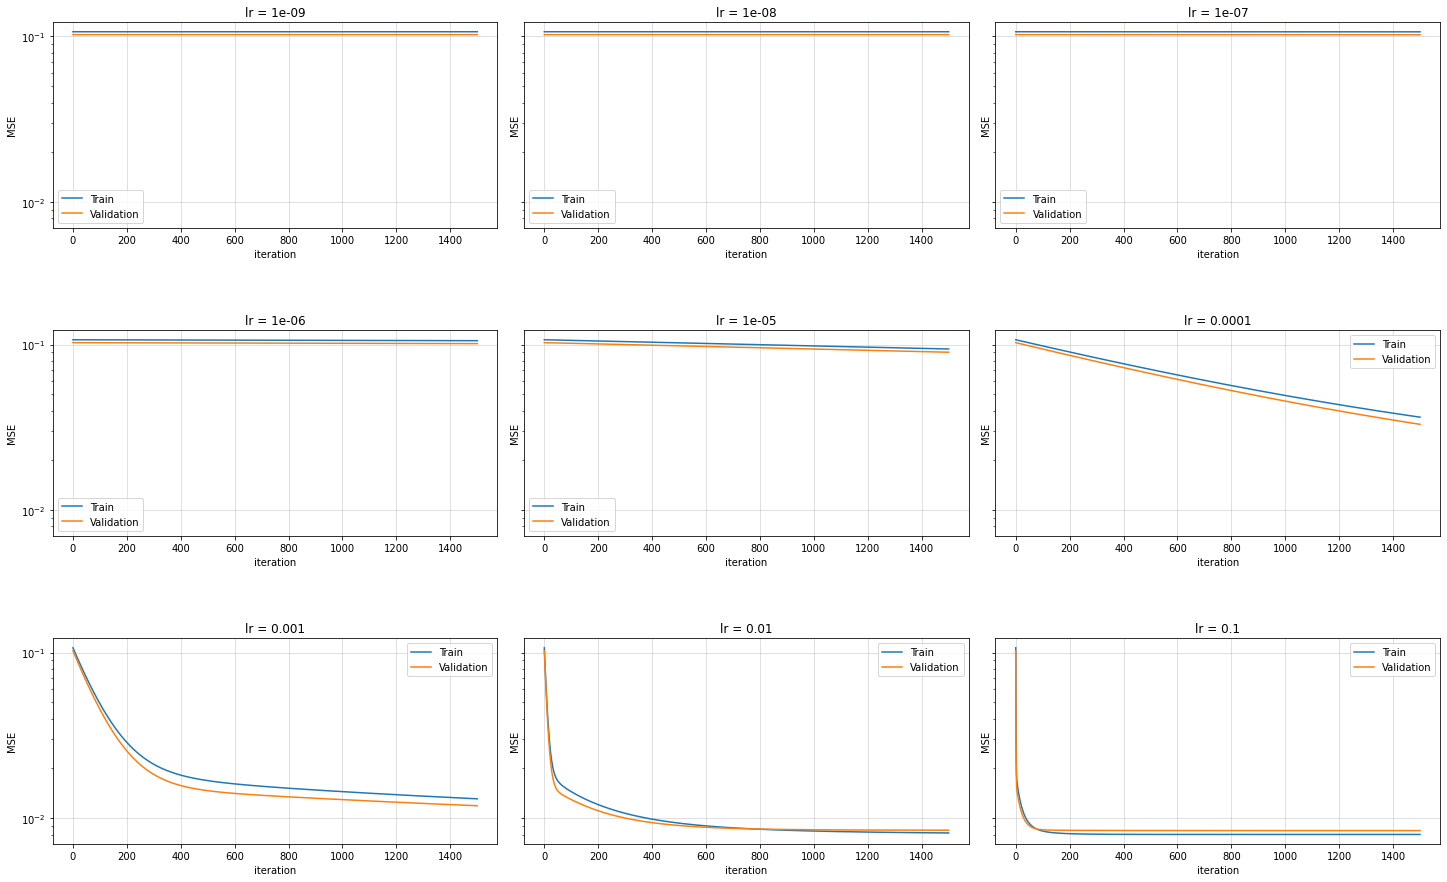

In [375]:
X_val = validation.drop(columns=['VirusScore', 'patient_id'])
y_val = validation['VirusScore']
test_lr(X_train, y_train, X_val, y_val)


#Section 3

##Q6

In [376]:
X_train = train.drop(columns=['patient_id', 'VirusScore'])
y_train = train['VirusScore']

import sklearn.dummy as dummy
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

dummy_regr = dummy.DummyRegressor(strategy='mean')
dummy_scores = cross_validate(dummy_regr, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

train_results_means = []
test_results_means = []
train_results_means.append(np.abs(dummy_scores['train_score'].mean()))
test_results_means.append(np.abs(dummy_scores['test_score'].mean()))

In [377]:
print('dummy train mse', train_results_means)
print('dummy validation mse', test_results_means)

dummy train mse [0.020104383973524306]
dummy validation mse [0.020117654654947918]


In [378]:
# retrain dummy regressor
dummy_regr.fit(X_train, y_train)

DummyRegressor()

#Section 4

##Q7

In [379]:
from sklearn.linear_model import Ridge 

alphas = np.logspace(-3, 7, 12)
train_results_means = []
test_results_means = []

for alpha in alphas:
  ridge_regr = Ridge(fit_intercept=True, alpha=alpha)
  scores = cross_validate(ridge_regr, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  train_results_means.append(np.abs(scores['train_score'].mean()))
  test_results_means.append(np.abs(scores['test_score'].mean()))

Text(0, 0.5, 'mse')

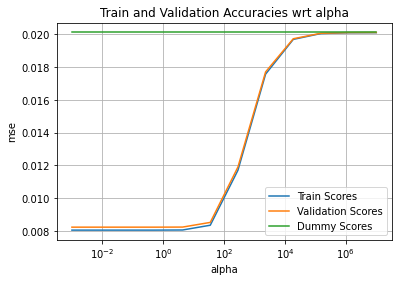

In [380]:
dummy_res = np.abs(dummy_scores['test_score'].mean())

fig, ax = plt.subplots()
ax.plot(alphas, train_results_means, Label='Train Scores')
ax.plot(alphas, test_results_means, Label='Validation Scores')
ax.plot(alphas, [dummy_res]*12, Label ='Dummy Scores')
plt.legend()
plt.grid()
plt.title('Train and Validation Accuracies wrt alpha')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')


In [381]:
min_alpha_idx = min(range(len(test_results_means)), key=test_results_means.__getitem__)
min_alpha = alphas[min_alpha_idx]
print(min_alpha)

0.5336699231206307


In [382]:
print('ridge train mse', train_results_means[min_alpha_idx])
print('ridge min train mse', min(train_results_means))
print('ridge validatrion mse', min(test_results_means))

ridge train mse 0.008049010023607115
ridge min train mse 0.008048886087414015
ridge validatrion mse 0.008229431038889191


In [383]:
best_alpha_ridge_regr = Ridge(fit_intercept=True, alpha=min_alpha)
best_alpha_ridge_regr.fit(X_train, y_train)

Ridge(alpha=0.5336699231206307)

##Q9

In [384]:
coefficients = np.abs(best_alpha_ridge_regr.coef_)
features_names = list(X_train.columns)
coefficients = list(coefficients)

In [385]:
max_coefficient_features = []
coefficients_copy = copy.deepcopy(coefficients)
for _ in range(5):
  max_coefficient = max(coefficients_copy)
  max_coefficient_idx = coefficients_copy.index(max_coefficient)
  max_coefficient_feature = features_names[max_coefficient_idx]
  features_names.remove(max_coefficient_feature)
  coefficients_copy.remove(max_coefficient)
  max_coefficient_features.append((max_coefficient_feature, max_coefficient))

print(max_coefficient_features)

[('shortness_of_breath', 0.24901172556372625), ('num_of_siblings', 0.14958042960731724), ('fever', 0.11775319779935671), ('blood_type_contains_A', 0.09734793327764456), ('household_income', 0.04409165403557111)]


##Q10

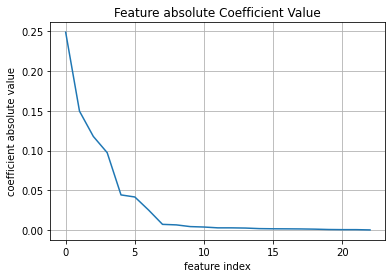

In [386]:
coefficients.sort(reverse=True)
fig, ax = plt.subplots()
x = np.arange(0, X_train.columns.size)
ax.plot(x, coefficients)
ax.set_xlabel('feature index')
ax.set_ylabel('coefficient absolute value')
ax.set_title('Feature absolute Coefficient Value')
plt.grid()
plt.show()

#Section 5

##Q11

In [387]:
from sklearn.linear_model import Lasso 
alphas = np.logspace(-6, 6, 12)
train_results_means = []
test_results_means = []

for alpha in alphas:
  lasso_regr = Lasso(fit_intercept=True, alpha=alpha)
  scores = cross_validate(lasso_regr, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  train_results_means.append(np.abs(scores['train_score'].mean()))
  test_results_means.append(np.abs(scores['test_score'].mean()))

Text(0, 0.5, 'mse')

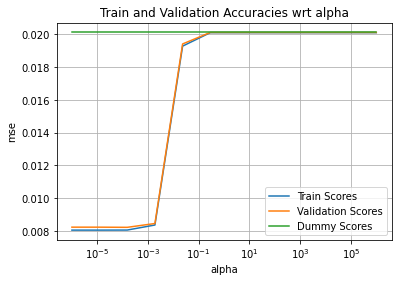

In [388]:
dummy_res = np.abs(dummy_scores['test_score'].mean())

fig, ax = plt.subplots()
ax.plot(alphas, train_results_means, Label='Train Scores')
ax.plot(alphas, test_results_means, Label='Validation Scores')
ax.plot(alphas, [dummy_res]*12, Label ='Dummy Scores')
plt.legend()
plt.grid()
plt.title('Train and Validation Accuracies wrt alpha')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')

In [389]:
min_alpha_idx = min(range(len(test_results_means)), key=test_results_means.__getitem__)
min_alpha_lasso = alphas[min_alpha_idx]
print(min_alpha_lasso)

0.0001519911082952933


In [390]:
print('lasso train min mse', min(train_results_means))
print('lasso train mse', train_results_means[min_alpha_idx])
print('lasso validation mse', min(test_results_means))

lasso train min mse 0.008048886263401368
lasso train mse 0.00805266173584907
lasso validation mse 0.008219139821378448


In [391]:
# best performance hyperparameter is alpha=10^-5
best_alpha_lasso_regr = Lasso(fit_intercept=True, alpha=min_alpha_lasso)
best_alpha_lasso_regr.fit(X_train, y_train)

Lasso(alpha=0.0001519911082952933)

##Q14

In [392]:
coefficients = np.abs(best_alpha_lasso_regr.coef_)
features_names = list(X_train.columns)
coefficients = list(coefficients)

In [393]:
max_coefficient_features = []
coefficients_copy = copy.deepcopy(coefficients)
for _ in range(5):
  max_coefficient = max(coefficients_copy)
  max_coefficient_idx = coefficients_copy.index(max_coefficient)
  max_coefficient_feature = features_names[max_coefficient_idx]
  features_names.remove(max_coefficient_feature)
  coefficients_copy.remove(max_coefficient)
  max_coefficient_features.append((max_coefficient_feature, max_coefficient))

print(max_coefficient_features)

[('shortness_of_breath', 0.24949493635101844), ('num_of_siblings', 0.146943860602671), ('fever', 0.11647161851074479), ('blood_type_contains_A', 0.09670782550150298), ('household_income', 0.04124200487387142)]


##Q15

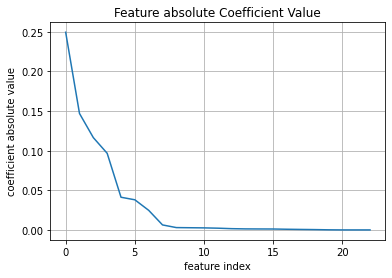

In [394]:
coefficients.sort(reverse=True)
fig, ax = plt.subplots()
x = np.arange(0, X_train.columns.size)
ax.plot(x, coefficients)
ax.set_xlabel('feature index')
ax.set_ylabel('coefficient absolute value')
ax.set_title('Feature absolute Coefficient Value')
plt.grid()
plt.show()

# Section 6

In [395]:
test_copy = test.copy()
train_copy = train.copy()

X_train_copy = train_copy.drop(columns=['VirusScore', 'patient_id'])
y_train_copy = train_copy['VirusScore']

In [396]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_copy = poly.fit_transform(X_train_copy)

##Q18

In [397]:
alphas = np.logspace(-4, 7, 12)
train_results_means = []
test_results_means = []

for alpha in alphas:
  ridge_regr = Ridge(fit_intercept=True, alpha=alpha)
  scores = cross_validate(ridge_regr, X_train_copy, y_train_copy, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  train_results_means.append(np.abs(scores['train_score'].mean()))
  test_results_means.append(np.abs(scores['test_score'].mean()))

Text(0, 0.5, 'mse')

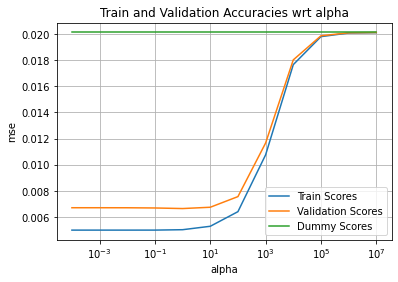

In [398]:
dummy_res = np.abs(dummy_scores['test_score'].mean())

fig, ax = plt.subplots()
ax.plot(alphas, train_results_means, Label='Train Scores')
ax.plot(alphas, test_results_means, Label='Validation Scores')
ax.plot(alphas, [dummy_res]*12, Label ='Dummy Scores')
plt.legend()
plt.grid()
plt.title('Train and Validation Accuracies wrt alpha')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')

In [399]:
min_alpha_idx = min(range(len(test_results_means)), key=test_results_means.__getitem__)
min_alpha_poly = alphas[min_alpha_idx]
print(min_alpha_poly)

1.0


In [400]:
print('poly train mse min', min(train_results_means))
print('poly train mse', train_results_means[min_alpha_idx])
print('poly validation mse', min(test_results_means))

poly train mse min 0.0050096317907985435
poly train mse 0.005041146167040725
poly validation mse 0.006657723854512796


In [401]:
best_alpha_poly_regr = Ridge(fit_intercept=True, alpha=min_alpha_poly)
best_alpha_poly_regr.fit(X_train_copy, y_train_copy)

Ridge()

#Section 7

##Q20

In [402]:
blood_type = [None]*(len(test['patient_id']))
blood_types = ['blood_type_A+', 'blood_type_A-', 'blood_type_B+', 'blood_type_B-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_O+', 'blood_type_O-']
for person in range(len(test['patient_id'])):
  for idx in range(len(blood_types)):
    if test[blood_types[idx]].iloc[person] == 1:
      blood_type[person] = blood_types[idx][11:]
    
test['blood_type'] = blood_type

blood_types_with_A = test['blood_type'].str.contains('A')
blood_types_with_A = blood_types_with_A.astype(int)
test['blood_type_contains_A'] = blood_types_with_A

test = test.drop(columns=['blood_type', 'blood_type_A+', 'blood_type_A-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_B+',
                            'blood_type_B-', 'blood_type_O+', 'blood_type_O-'])

In [403]:
X_test = test.drop(columns=['VirusScore', 'patient_id'])
y_test = test['VirusScore']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_test_poly = poly.fit_transform(X_test)

y_predict_dummy = dummy_regr.predict(X_test)
y_predict_ridge = best_alpha_ridge_regr.predict(X_test)
y_predict_lasso = best_alpha_lasso_regr.predict(X_test)
y_predict_poly = best_alpha_poly_regr.predict(X_test_poly)


In [404]:
from sklearn.metrics import mean_squared_error


dummy_mse = mean_squared_error(y_true=y_test, y_pred=y_predict_dummy)
ridge_mse = mean_squared_error(y_true=y_test, y_pred=y_predict_ridge)
lasso_mse = mean_squared_error(y_true=y_test, y_pred=y_predict_lasso)
poly_mse = mean_squared_error(y_true=y_test, y_pred=y_predict_poly)


In [405]:
print('dummy_mse:', dummy_mse)
print('ridge_mse', ridge_mse)
print('lasso_mse', lasso_mse)
print('poly_mse', poly_mse)

dummy_mse: 0.021030017291666668
ridge_mse 0.00878415703389226
lasso_mse 0.008781036421647221
poly_mse 0.007796477853244047


# Section 8 - Bonus

#Section 9

In [406]:
unlabeled_data = pd.read_csv('virus_unlabeled.csv')  
data = pd.read_csv('virus_labeled.csv')
from datetime import datetime

def reformat_date(date):
  if isinstance(date, str):
    return datetime.strptime(date, "%d-%m-%y").strftime("%Y-%m-%d")
  return date

unlabeled_data['pcr_date'] = unlabeled_data['pcr_date'].apply(reformat_date)



In [407]:
data, unlabeled_data = prepare_data(unlabeled_data, data)   


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [408]:
blood_type = [None]*(len(data['patient_id']))
blood_types = ['blood_type_A+', 'blood_type_A-', 'blood_type_B+', 'blood_type_B-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_O+', 'blood_type_O-']
for person in range(len(data['patient_id'])):
  for idx in range(len(blood_types)):
    if data[blood_types[idx]].iloc[person] == 1:
      blood_type[person] = blood_types[idx][11:]
    
data['blood_type'] = blood_type

blood_types_with_A = data['blood_type'].str.contains('A')
blood_types_with_A = blood_types_with_A.astype(int)
data['blood_type_contains_A'] = blood_types_with_A

data = data.drop(columns=['blood_type', 'blood_type_A+', 'blood_type_A-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_B+',
                            'blood_type_B-', 'blood_type_O+', 'blood_type_O-'])

In [409]:
blood_type = [None]*(len(unlabeled_data['patient_id']))
blood_types = ['blood_type_A+', 'blood_type_A-', 'blood_type_B+', 'blood_type_B-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_O+', 'blood_type_O-']
for person in range(len(unlabeled_data['patient_id'])):
  for idx in range(len(blood_types)):
    if unlabeled_data[blood_types[idx]].iloc[person] == 1:
      blood_type[person] = blood_types[idx][11:]
    
unlabeled_data['blood_type'] = blood_type

blood_types_with_A = unlabeled_data['blood_type'].str.contains('A')
blood_types_with_A = blood_types_with_A.astype(int)
unlabeled_data['blood_type_contains_A'] = blood_types_with_A

unlabeled_data = unlabeled_data.drop(columns=['blood_type', 'blood_type_A+', 'blood_type_A-', 'blood_type_AB+', 'blood_type_AB-', 'blood_type_B+',
                            'blood_type_B-', 'blood_type_O+', 'blood_type_O-'])

In [410]:
X_train = data.drop(columns=['VirusScore', 'patient_id'])
y_train = data['VirusScore']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

In [411]:
# train models on entire data

ridge_regr_sec_4 = Ridge(fit_intercept=True, alpha=1)
ridge_regr_sec_4.fit(X_train, y_train)

lasso_regr_sec_5 = Lasso(fit_intercept=True, alpha=1e-5)
lasso_regr_sec_5.fit(X_train, y_train)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

poly_regr_sec_6 = Ridge(fit_intercept=True, alpha=10)
poly_regr_sec_6.fit(X_train_poly, y_train)

Ridge(alpha=10)

In [412]:
X_test = unlabeled_data.drop(columns='patient_id')

poly = PolynomialFeatures(degree=2, include_bias=False)
X_test_poly = poly.fit_transform(X_test)


In [413]:
y_predict_sec_4 = ridge_regr_sec_4.predict(X_test)
y_predict_sec_5 = lasso_regr_sec_5.predict(X_test)
y_predict_sec_6 = poly_regr_sec_6.predict(X_test_poly)                                              

In [414]:
df_sec_4 = {'patient_id': unlabeled_data['patient_id'], 'VirusScore': y_predict_sec_4}
df_sec_4 = pd.DataFrame(df_sec_4)

df_sec_5 = {'patient_id': unlabeled_data['patient_id'], 'VirusScore': y_predict_sec_5}
df_sec_5 = pd.DataFrame(df_sec_5)

df_sec_6 = {'patient_id': unlabeled_data['patient_id'], 'VirusScore': y_predict_sec_6}
df_sec_6 = pd.DataFrame(df_sec_6)

In [415]:
df_sec_4.to_csv('pred_4.csv', index=False)
df_sec_5.to_csv('pred_5.csv', index=False)
df_sec_6.to_csv('pred_6.csv', index=False)

In [416]:
df = pd.read_csv('pred_4.csv')

In [417]:
df.shape

(1000, 2)